In [1]:
import re

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

Lets read the data and enreach it by 
- total llength of the text in characters
- number of sentences
- median sentence length
- convert authors to categorical representation

Then we cut longest 1% of texts. It not really affect the future model, but plots looks ugly w/o this. 

In [2]:
df = pd.read_csv('authors_dataset.csv')
df['len'] = df.text.apply(lambda x: len(x))
df['num_phrases'] = df.text.apply(lambda x: len(x.split('.')))
df['phrase_len'] = df.text.apply(lambda x: np.median([len(p) for p in x.split('.')]))
df['author'] = pd.Categorical(df.author)

df = df[df.len <= np.percentile(df.len, 99)]
df.head()

,id,text,author,len,num_phrases,phrase_len
0,id26305,"This process, however, afforded me no means of...",EAP,231,2,115.0
1,id17569,It never once occurred to me that the fumbling...,HPL,71,2,35.0
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200,2,99.5
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206,2,102.5
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174,2,86.5


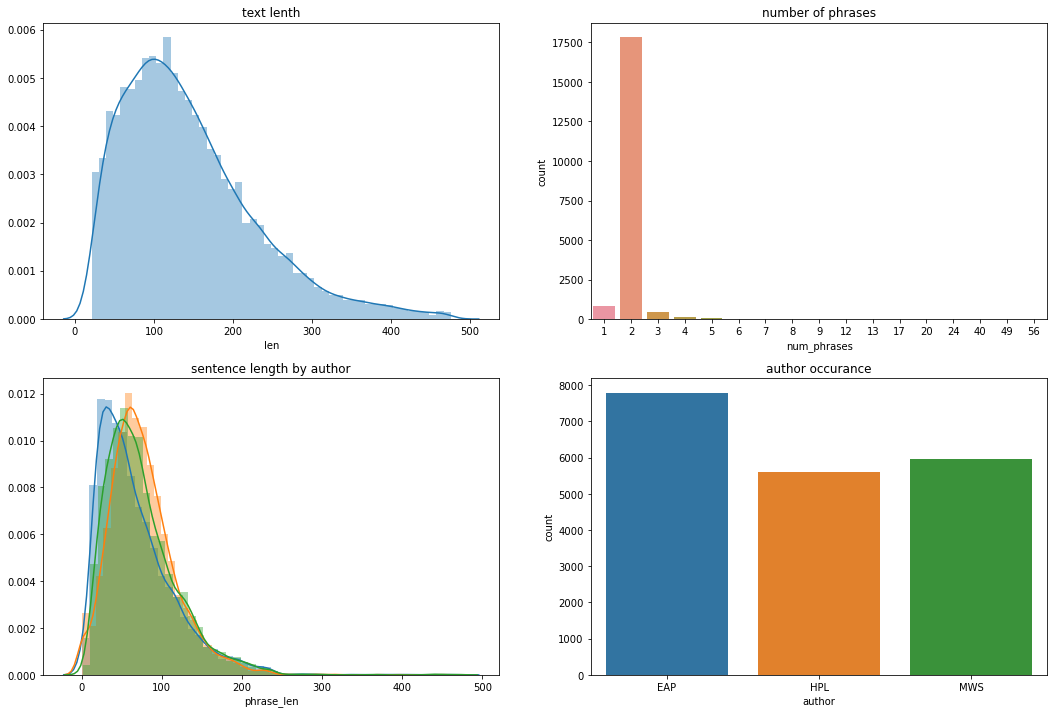

In [3]:
plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.title('text lenth')
sns.distplot(df.len)

plt.subplot(2,2,2)
plt.title('number of phrases')
sns.countplot(df.num_phrases)

plt.subplot(2,2,3)
plt.title('sentence length by author')
for author in df.author.unique():
    sns.distplot(df.phrase_len[df.author == author] )
    
plt.subplot(2,2,4)
plt.title('author occurance')
sns.countplot(df.author)
    

In [4]:
def get_ngrams(phrase, n=1):
    """
        extract n-grams from text
    """
    words = phrase.split(' ')
    words = [word.lower() for word in words if len(word) > 0]
    grams = []
    for i in range(len(words) - n + 1):
        grams += [" ".join(words[i:i+n])]    
    return grams


def naive_embedding(text, dim_size):
    """
        computes online one-hot representation of n-grams
        then sums over text.
    """
    grams = [get_ngrams(phrase) for phrase in re.split("[;,.!?]", text)]
    codes = []
    for k in range(1, 3):        
        codes += [hash(item) % dim_size for sublist in grams for item in sublist]

    vector = np.zeros(dim_size)
    for c in codes:
        vector[c] += 1
    return vector

So, create features matrix X (using naive embedding) and label y;

Then split it to train (80%) and test (20%)

In [5]:
TOK_DIM=1024*256
X = np.zeros((df.shape[0], TOK_DIM))
for k in range(df.shape[0]):
    X[k, :] = naive_embedding(df.iloc[k].text, TOK_DIM)
    
X = X[:, X.sum(axis=0) > 0]
y = df.author.cat.codes.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Finaly, create model and train it.
I chose simple FFNN, for speed (in development) and simplisity.

In [ ]:
model = MLPClassifier((5,), max_iter=1000, alpha=0.1, early_stopping=True, validation_fraction=0.2)
model.fit(X_train, y_train)


p_train = model.predict(X_train)
p_test  = model.predict(X_test)

print('Train log loss: %.2f' % log_loss(y_train, model.predict_proba(X_train)))
print('Tests log loss: %.2f' % log_loss(y_test, model.predict_proba(X_test)))
print('---------------------')
print('Train accuracy: %.2f' % accuracy_score(y_train, y_train))
print('Tests accuracy: %.2f' % accuracy_score(y_test, p_test))